# ПРОЕКТ ДЛЯ ЭКЗАМЕНА

В данном проекте мы изучаем датасет https://www.kaggle.com/datasets/danofer/sf-parks
с официальной оценкой парков в Сан-Франциско

Зачем бизнесу этот проект? Мэрия Сан-Франциско определяет по результатам опроса о парках, кого стоит финансировать, но хочет понять, кого финансировать в следующем квартале. Для этого мы хотим определить, что влияет на оценку парков, так как оценивание происходит вслепую.
Цель проекта: научиться прогнозировать рейтинг парков (делим городской бюджет, так сказать).
После этого хотим классифицировать парки по их показателю для дальнейшего принятия решений. Если классификация не получится, то провести анализ временных рядов для оценки влияния сезонности и тренда в парках.

Для начала посмотрим на сам датасет:

In [67]:
import pandas as pd
import numpy as np

# Read in data into a dataframe
df = pd.read_csv('SF_Park_Scores.csv')

# Display top of dataframe
df.head()

,ParkID,PSA,Park,FQ,Score,Facility Type,Facility Name,Address,State,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
0,86,PSA4,Carl Larsen Park,FY05Q3,0.795,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
1,13,PSA4,Junipero Serra Playground,FY05Q3,0.957,Ball Field,Glen ball fields,Diamond & Farnum Street,CA,94131.0,NaN,124520.486259,1891.675445,2.858608,-122.440592,37.736008
2,9,PSA4,Rolph Nicol Playground,FY05Q3,0.864,Dog Play Area,Douglass dog play area,26th & Douglass Street,CA,94114.0,NaN,70655.337234,1153.019646,1.622030,-122.438895,37.746741
3,117,PSA2,Alamo Square,FY05Q4,0.857,Restroom,Gilman Bathrooms,Gilman Ave & Griffith,CA,94124.0,NaN,378.668603,94.257319,0.008693,-122.388772,37.717179
4,60,PSA6,Jose Coronado Playground,FY05Q4,0.859,Basketball Court,GGP1 Panhandle Basketball Courts,Stanyan & Great Hwy,CA,94117.0,NaN,4645.553645,279.465313,0.106648,-122.448380,37.772304


Заметим, что в датасет собраны значения из разных кварталов года. Уберем лишнее

In [68]:
df = df[df['FQ'] == 'FY13Q4']
df.head()

,ParkID,PSA,Park,FQ,Score,Facility Type,Facility Name,Address,State,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
4539,957226,PSA4,Chester-Palmetto Mini Park,FY13Q4,0.923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4540,73,PSA5,Seward Mini Park,FY13Q4,0.947,Basketball Court,Koshland Park Basketball Courts,Page & Buchanan,CA,94102.0,NaN,1589.219135,151.936532,0.036484,-122.426992,37.773278
4541,24,PSA6,Garfield Square,FY13Q4,1.000,Ball Field,McCoppin Ball Fields,24th & Taraval,CA,94116.0,NaN,77985.770037,1152.138065,1.790314,-122.479877,37.744020
4542,121,PSA2,Buchanan Street Mall,FY13Q4,0.817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4543,127,PSA2,Cottage Row Mini Park,FY13Q4,1.000,Restroom,GGP2 Japanese Tea Garden Women's Bathrm,Stanyan & Great Hwy,CA,94117.0,NaN,390.480832,116.416339,0.008964,-122.469441,37.770474


## Очистка данных

Проверим, правильно ли мы распознали алгоритмом типы данных: на самом деле в основном да

In [69]:
df.shape[0]

183

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 4539 to 4721
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkID            183 non-null    int64  
 1   PSA               183 non-null    object 
 2   Park              183 non-null    object 
 3   FQ                183 non-null    object 
 4   Score             183 non-null    float64
 5   Facility Type     140 non-null    object 
 6   Facility Name     140 non-null    object 
 7   Address           140 non-null    object 
 8   State             140 non-null    object 
 9   Zipcode           140 non-null    float64
 10  Floor Count       39 non-null     float64
 11  Square Feet       140 non-null    float64
 12  Perimeter Length  140 non-null    float64
 13  Acres             140 non-null    float64
 14  Longitude         140 non-null    float64
 15  Latitude          140 non-null    float64
dtypes: float64(8), int64(1), object(7)
memory usa

In [71]:
df.describe()

,ParkID,Score,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
count,183.000000,183.000000,140.000000,39.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,106967.885246,0.913945,94117.064286,1.205128,25183.892186,546.469356,0.578145,-122.444350,37.756696
std,263290.167490,0.089132,7.707990,0.570295,51837.507555,711.867470,1.190030,0.032611,0.025187
min,1.000000,0.378000,94102.000000,1.000000,213.120658,60.729108,0.004893,-122.510114,37.708446
25%,58.000000,0.877000,94112.000000,1.000000,1552.777148,182.889207,0.035647,-122.470020,37.738228
50%,116.000000,0.933000,94116.000000,1.000000,5030.562687,304.048412,0.115486,-122.438732,37.759507
75%,171.000000,0.981000,94121.000000,1.000000,10725.763962,576.963009,0.246231,-122.416646,37.776397
max,957226.000000,1.000000,94134.000000,4.000000,338875.045245,5432.156001,7.779532,-122.383721,37.806461


In [72]:
df.head(2)

,ParkID,PSA,Park,FQ,Score,Facility Type,Facility Name,Address,State,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
4539,957226,PSA4,Chester-Palmetto Mini Park,FY13Q4,0.923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4540,73,PSA5,Seward Mini Park,FY13Q4,0.947,Basketball Court,Koshland Park Basketball Courts,Page & Buchanan,CA,94102.0,NaN,1589.219135,151.936532,0.036484,-122.426992,37.773278


Тем не менее, в парках у нас есть столбец Floor Count: оказалось, что это высота максимального здания в парке, если оно есть. Если его нет - выводится nan. Заменим эти пропуски логичными нулями.

In [73]:
print(df['Floor Count'].unique())

[nan  1.  4.  2.]


In [74]:
# Заполняем пропуски в 'Floor Count' нулями
df['Floor Count'] = df['Floor Count'].fillna(0)

# Удаляем строки, где Longitude равно NaN
df.dropna(subset=['Longitude'], inplace=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 4540 to 4721
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkID            140 non-null    int64  
 1   PSA               140 non-null    object 
 2   Park              140 non-null    object 
 3   FQ                140 non-null    object 
 4   Score             140 non-null    float64
 5   Facility Type     140 non-null    object 
 6   Facility Name     140 non-null    object 
 7   Address           140 non-null    object 
 8   State             140 non-null    object 
 9   Zipcode           140 non-null    float64
 10  Floor Count       140 non-null    float64
 11  Square Feet       140 non-null    float64
 12  Perimeter Length  140 non-null    float64
 13  Acres             140 non-null    float64
 14  Longitude         140 non-null    float64
 15  Latitude          140 non-null    float64
dtypes: float64(8), int64(1), object(7)
memory usa

Также заметим, что кажется два парка играют в голосование нечестно и имеют 3-4 различные оценки и больше за 1 квартал. Вычеркнем их из финансирования за неспортивное поведение

In [76]:
print(len(df['ParkID'].unique()))
print(df[df.duplicated(subset='Park', keep=False)].sort_values(by='ParkID'))

135
      ParkID   PSA               Park      FQ  Score Facility Type  \
4570      10  PSA4   Lake Merced Park  FY13Q4  0.653    Ball Field   
4609      10  PSA4   Lake Merced Park  FY13Q4  0.941    Ball Field   
4682      10  PSA4   Lake Merced Park  FY13Q4  0.890    Ball Field   
4644      10  PSA4   Lake Merced Park  FY13Q4  0.727    Ball Field   
4603      28  PSA3  John McLaren Park  FY13Q4  0.714    Ball Field   
4562      28  PSA3  John McLaren Park  FY13Q4  0.925    Ball Field   
4680      28  PSA3  John McLaren Park  FY13Q4  0.765    Ball Field   

                  Facility Name             Address State  Zipcode  \
4570  Eureka Valley Ball Fields     100 Collingwood    CA  94114.0   
4609  Eureka Valley Ball Fields     100 Collingwood    CA  94114.0   
4682  Eureka Valley Ball Fields     100 Collingwood    CA  94114.0   
4644  Eureka Valley Ball Fields     100 Collingwood    CA  94114.0   
4603       Parkside ball fields  28th Ave & Vicente    CA  94116.0   
4562       Park

In [77]:
df.drop(df[df['ParkID'].isin([10, 28])].index, inplace=True)

## Разведочный анализ данных

Посмотрим, как на нашу переменную будут влиять разные признаки

In [78]:
df

,ParkID,PSA,Park,FQ,Score,Facility Type,Facility Name,Address,State,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
4540,73,PSA5,Seward Mini Park,FY13Q4,0.947,Basketball Court,Koshland Park Basketball Courts,Page & Buchanan,CA,94102.0,0.0,1589.219135,151.936532,0.036484,-122.426992,37.773278
4541,24,PSA6,Garfield Square,FY13Q4,1.000,Ball Field,McCoppin Ball Fields,24th & Taraval,CA,94116.0,0.0,77985.770037,1152.138065,1.790314,-122.479877,37.744020
4543,127,PSA2,Cottage Row Mini Park,FY13Q4,1.000,Restroom,GGP2 Japanese Tea Garden Women's Bathrm,Stanyan & Great Hwy,CA,94117.0,0.0,390.480832,116.416339,0.008964,-122.469441,37.770474
4545,22,PSA5,Upper Noe Recreation Center,FY13Q4,0.967,Ball Field,Laurel Ball Fields,Euclid & Collins Streets,CA,94118.0,0.0,24075.722705,622.987683,0.552705,-122.450874,37.783914
4547,166,PSA1,Julius Kahn Playground,FY13Q4,0.991,Clubhouse,Gilman Clubhouse,Gilman Ave & Griffith,CA,94124.0,1.0,3479.969363,236.523816,0.079889,-122.388330,37.716826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4717,125,PSA2,Hamilton Recreation Center,FY13Q4,0.929,Restroom,GGP6 Chain of Lakes Bathroom,Stanyan & Great Hwy,CA,94117.0,0.0,855.376719,118.288607,0.019637,-122.501806,37.767971
4718,126,PSA2,Japantown Peace Plaza,FY13Q4,1.000,Restroom,GGP1 Conservatory Bathroom,Stanyan & Great Hwy,CA,94117.0,0.0,1292.929871,145.490342,0.029682,-122.460775,37.772596
4719,163,PSA4,Lower Great Highway,FY13Q4,0.866,Clubhouse,Douglass Clubhouse,26th & Douglass St,CA,94114.0,1.0,1125.830141,175.939620,0.025846,-122.438397,37.747807
4720,50,PSA6,James Rolph Jr. Playground,FY13Q4,0.896,Basketball Court,Cabrillo Basketball Courts,38th Ave & Cabrillo,CA,94121.0,0.0,7295.764074,488.949514,0.167488,-122.498707,37.772782


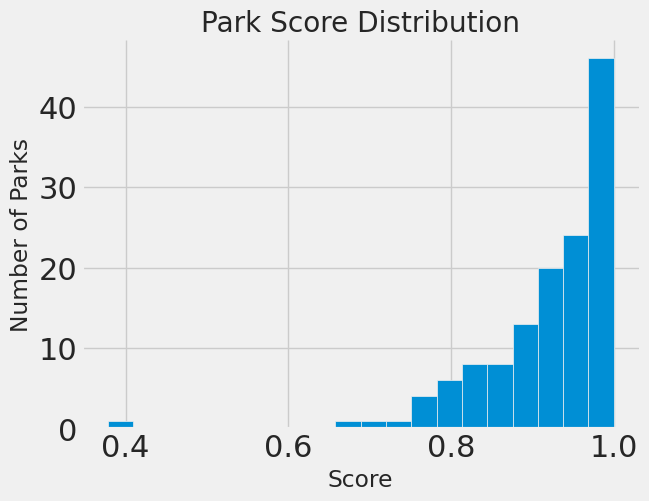

In [79]:
# @title Score

from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Park Score Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Score')
plt.ylabel('Number of Parks');

Как мы видим, подавляющее большинство парков получают наилучшую отметку. Попробуем избавиться от выбросов

In [80]:
first_quartile = df['Score'].describe()['25%']
third_quartile = df['Score'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df['Score'] > (first_quartile - 3 * iqr)) &
            (df['Score'] < (third_quartile + 3 * iqr))]

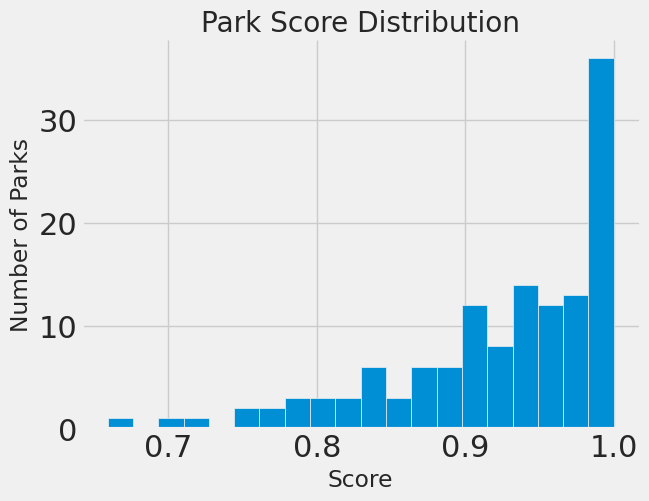

In [81]:
from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Park Score Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Score')
plt.ylabel('Number of Parks');

Распределение стало чуть лучше, но оно далеко от нормального

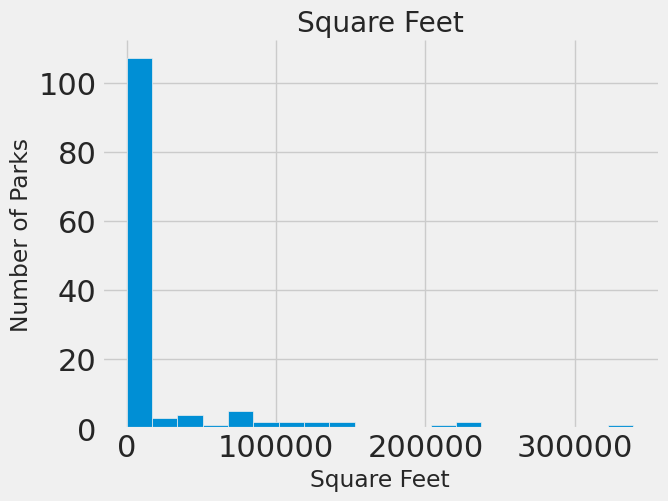

In [82]:
# @title Square Feet

from matplotlib import pyplot as plt
df['Square Feet'].plot(kind='hist', bins=20, title='Square Feet')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Square Feet')
plt.ylabel('Number of Parks');

Заметим, что большинство парков Сан-франциско маленькие

In [83]:
first_quartile = df['Square Feet'].describe()['25%']
third_quartile = df['Square Feet'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df['Square Feet'] > (first_quartile - 3 * iqr)) &
            (df['Square Feet'] < (third_quartile + 3 * iqr))]

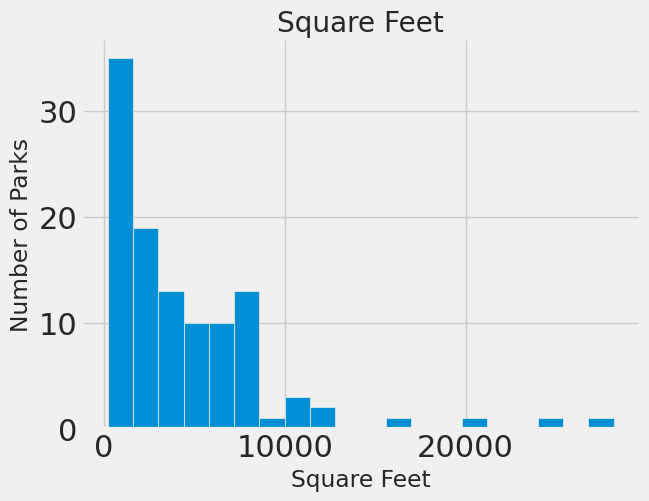

In [84]:
from matplotlib import pyplot as plt
df['Square Feet'].plot(kind='hist', bins=20, title='Square Feet')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Square Feet')
plt.ylabel('Number of Parks');

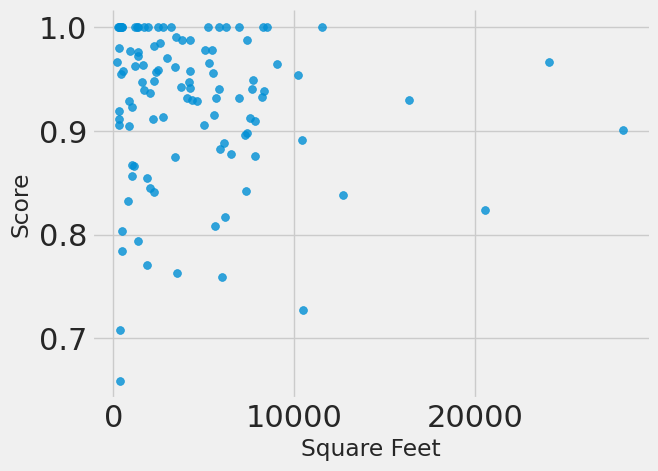

In [85]:
# @title Square Feet vs Score

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Square Feet', y='Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

При этом чем меньше площадь парка, тем лучше у парка оценка. Возможно паркам хватает денег финансирования за счет этого?

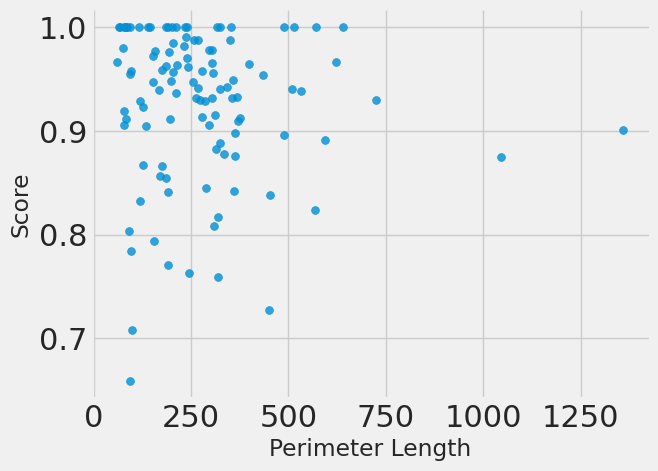

In [86]:
# @title Perimeter Length vs Score

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Perimeter Length', y='Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Абсолютно схожая тенденция есть и у периметра, хотя она чуть более плавная

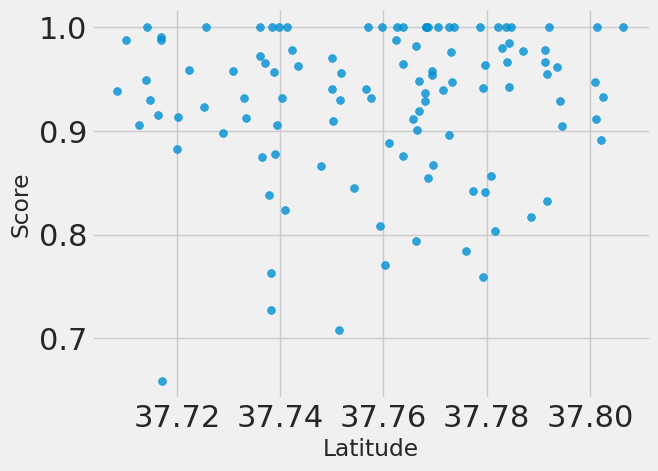

In [87]:
# @title Latitude vs Score

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Latitude', y='Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

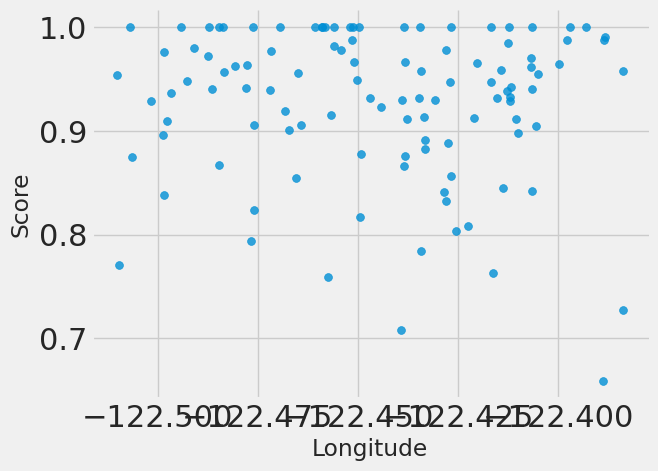

In [88]:
# @title Longitude vs Score

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Longitude', y='Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Южность и северность парка не влияют на оценку парка.

/tmp/ipython-input-89-2760895931.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Score', y='Facility Type', inner='stick', palette='Dark2')


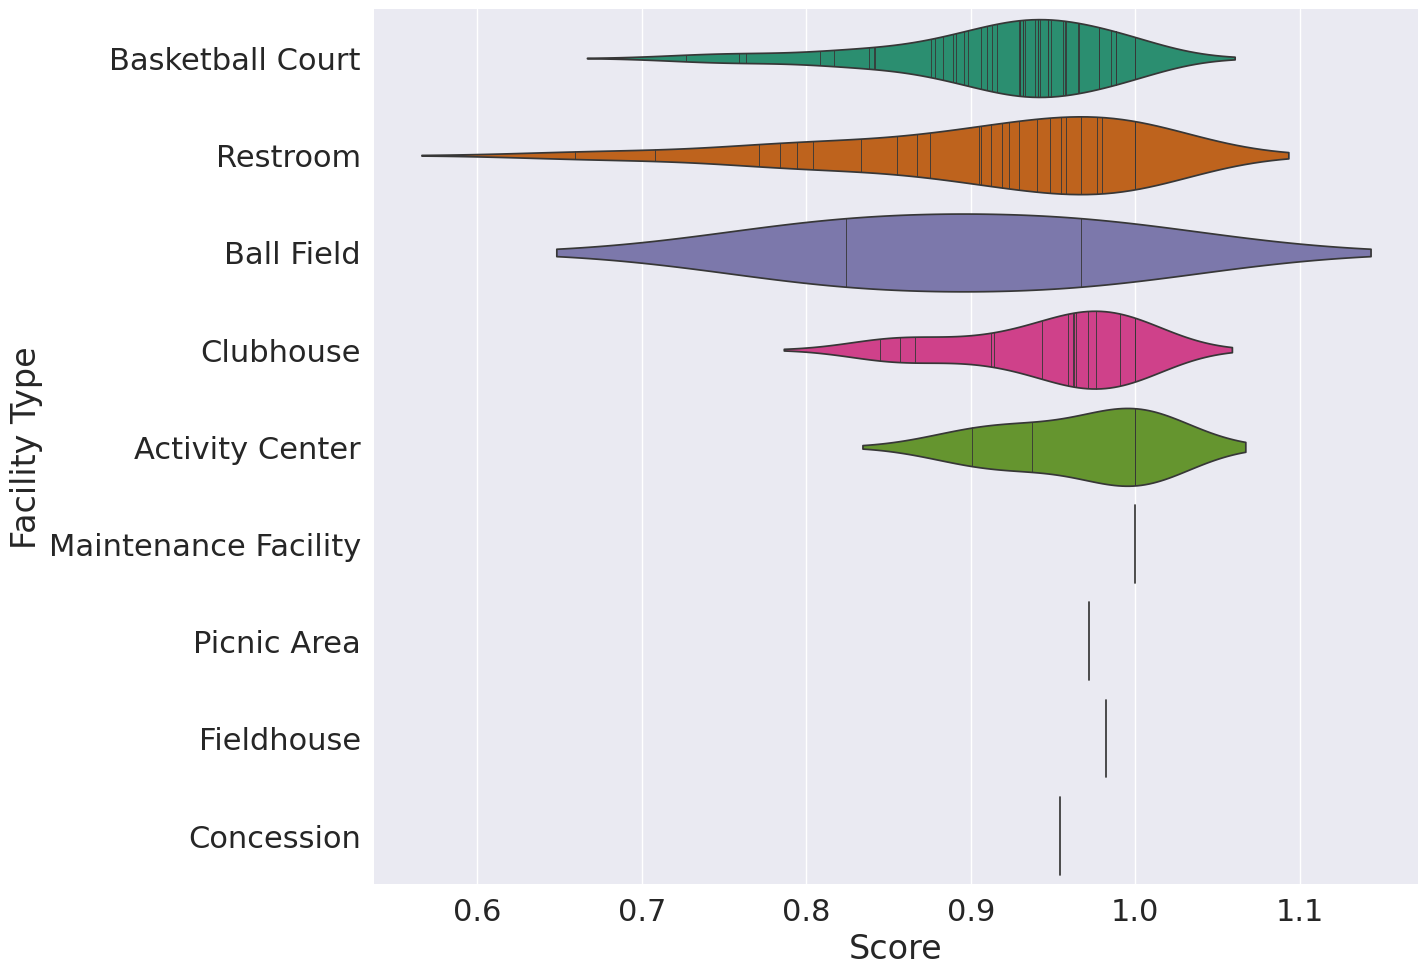

In [89]:
# @title Facility Type vs Score

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

figsize = (12, 1.2 * len(df['Facility Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Score', y='Facility Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

А вот тип зданий в парке напрямую влияет на то, какую оценку получит парк. Если это ресторан или центр активности - вероятность больше

/tmp/ipython-input-90-682372170.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Score', y='PSA', inner='stick', palette='Dark2')


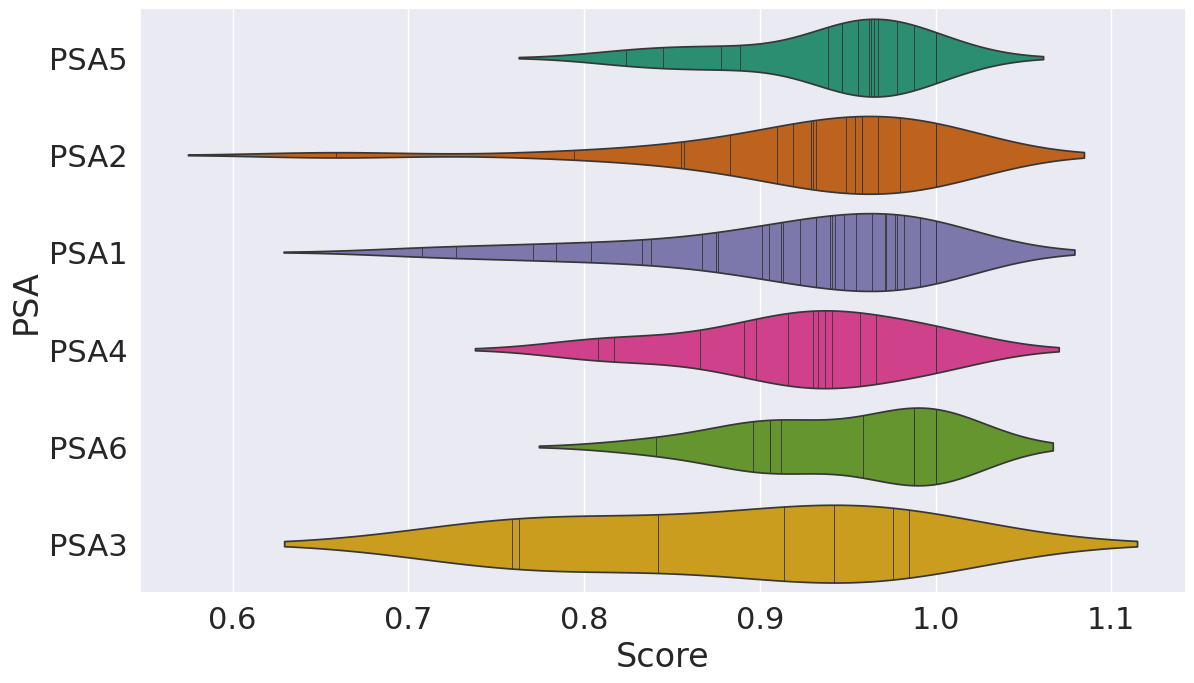

In [90]:
# @title PSA vs Score

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['PSA'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Score', y='PSA', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

PSA - неожиданно оказались категории БЕСЕДОК в парках. (гос программа, получается).
У народа явно больший фаворитизм в сторону 1-ой и 5-ой модели, но также нужно учитывать, что возможно просто они и закуплены в парках.

In [91]:
correlations_data = df[['Score', 'Square Feet', 'Perimeter Length', 'Acres', 'Longitude', 'Latitude']].corr()['Score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Longitude          -0.083436
Acres              -0.071210
Square Feet        -0.071210
Perimeter Length   -0.047381
Latitude            0.074364
Score               1.000000
Name: Score, dtype: float64 

Longitude          -0.083436
Acres              -0.071210
Square Feet        -0.071210
Perimeter Length   -0.047381
Latitude            0.074364
Score               1.000000
Name: Score, dtype: float64


Посмотрев на корреляцию, видно, что численные показатели практически не влияют на оценку парков, но при этом если и влияют, то в формате "Больше - хуже"

In [92]:
# Select the numeric columns
numeric_subset = df.select_dtypes('number')

for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = df[['Facility Type', 'PSA']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score
correlations = features.corr()['Score'].dropna().sort_values()
correlations

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Score
PSA_PSA3,-0.155656
Facility Type_Restroom,-0.131391
Facility Type_Basketball Court,-0.097771
Longitude,-0.083436
PSA_PSA1,-0.077104
Acres,-0.071210
Square Feet,-0.071210
Facility Type_Ball Field,-0.057885
sqrt_Square Feet,-0.053494
sqrt_Acres,-0.053494


Если смотреть на общие корреляции, то есть влияние количества этажей и типов взданий. Беседки влияют, но не экстремально. Остальное опять же влияет незначительно и негативно.

##Конструирование и выбор признаков

Теперь можно перейти к выбору и конструированию признаков: из численных возьмем только периметр и площадь парка, а для категорий создадим дамми переменные и почистим их

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 4540 to 4721
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkID            110 non-null    int64  
 1   PSA               110 non-null    object 
 2   Park              110 non-null    object 
 3   FQ                110 non-null    object 
 4   Score             110 non-null    float64
 5   Facility Type     110 non-null    object 
 6   Facility Name     110 non-null    object 
 7   Address           110 non-null    object 
 8   State             110 non-null    object 
 9   Zipcode           110 non-null    float64
 10  Floor Count       110 non-null    float64
 11  Square Feet       110 non-null    float64
 12  Perimeter Length  110 non-null    float64
 13  Acres             110 non-null    float64
 14  Longitude         110 non-null    float64
 15  Latitude          110 non-null    float64
dtypes: float64(8), int64(1), object(7)
memory usa

In [94]:
# Select the numeric columns
numeric_subset = df[['Score', 'Square Feet', 'Perimeter Length']]

for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = df[['Facility Type', 'Floor Count', 'PSA']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)


/tmp/ipython-input-94-1533180353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
/tmp/ipython-input-94-1533180353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['log_' + col] = np.log(numeric_subset[col])
/tmp/ipython-input-94-1533180353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [95]:
features.shape

(110, 23)

In [96]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        threshold: any features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    y = x['Score']
    x = x.drop(columns = ['Score'])

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    # Add the score back in to the data
    x['Score'] = y

    return x

In [97]:
features = remove_collinear_features(features, 0.6);

In [98]:
features  = features.dropna(axis=1, how = 'all')
features.shape

(110, 17)

In [99]:
features.columns

Index(['Square Feet', 'Perimeter Length', 'Floor Count',
       'Facility Type_Activity Center', 'Facility Type_Ball Field',
       'Facility Type_Clubhouse', 'Facility Type_Concession',
       'Facility Type_Fieldhouse', 'Facility Type_Maintenance Facility',
       'Facility Type_Picnic Area', 'PSA_PSA1', 'PSA_PSA2', 'PSA_PSA3',
       'PSA_PSA4', 'PSA_PSA5', 'PSA_PSA6', 'Score'],
      dtype='object')

### Базовый уровень

Для понимания, может ли у нас работать модель МО в данной задаче, создадим бейслайн:

In [100]:
targets = pd.DataFrame(features['Score'])
features = features.drop(columns='Score')
# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(77, 16)
(33, 16)
(77, 1)
(33, 1)


In [101]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 0.95
Baseline Performance on the test set: MAE = 0.0581


Кажется, предсказание в 95% это не очень просто, но во многом это потому что значения у нас приближенные, а выборка небольшая.

In [102]:
X.to_csv('training_features.csv', index = False)
X_test.to_csv('testing_features.csv', index = False)
y.to_csv('training_labels.csv', index = False)
y_test.to_csv('testing_labels.csv', index = False)

In [103]:
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (77, 16)
Testing Feature Size:   (33, 16)
Training Labels Size:   (77, 1)
Testing Labels Size:    (33, 1)


##Оценка и выбор моделей

###Масштабирование признаков

Для начала масштабируем все признаки в стандартный 0-1 диапазон, чтобы понимать их реальный вес

In [104]:
from sklearn.preprocessing import MinMaxScaler


In [105]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [106]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

###Реализация моделей

Попробуем наконец применить модели

In [107]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):

    # Train the model
    model.fit(X, y)

    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    # Return the performance metric
    return model_mae

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [109]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 0.0604


In [110]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 0.0680


In [111]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 0.0670


In [112]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 0.0731


In [113]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.0575


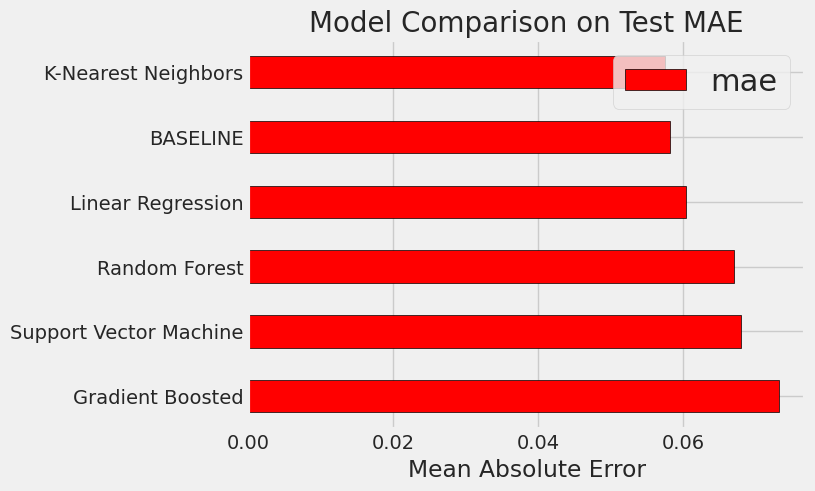

In [114]:
plt.style.use('fivethirtyeight')

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors', 'BASELINE'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae,
                                         gradient_boosted_mae, knn_mae, mae(y_test, baseline_guess)]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

Если смотреть только на мае, то во-первых с очень маленькой разницей от baseline у нас проходит только KNN. Стоит в принципе задуматься, что эта задача не очень применима для МО.
Но проблема на самом деле крылась не в ошибке, а в том, что модели здорово переобучились, и это мы увидим в следующей части

###KNN and Random Forest

Применим две модели KNN и Random forest

In [115]:
from sklearn.metrics import mean_squared_error, r2_score

In [116]:
random_forest.fit(X, y)

y_pred = random_forest.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"r^2: {r2}")
print(f"Mean Squared Error: {mse:.2f}")

r^2: -0.3721911604370929
Mean Squared Error: 0.01


In [117]:
importances = random_forest.feature_importances_

# train_features is the dataframe of training features
feature_list = list(train_features.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Perimeter Length,0.353562
1,Square Feet,0.349498
2,PSA_PSA3,0.103321
3,Floor Count,0.042066
4,PSA_PSA6,0.036762
5,PSA_PSA2,0.027081
6,PSA_PSA1,0.026466
7,Facility Type_Clubhouse,0.020516
8,PSA_PSA4,0.018713
9,Facility Type_Maintenance Facility,0.009491


У нас отрицательный R^2. Модель просто очень плохо считает на этих данных, увы.

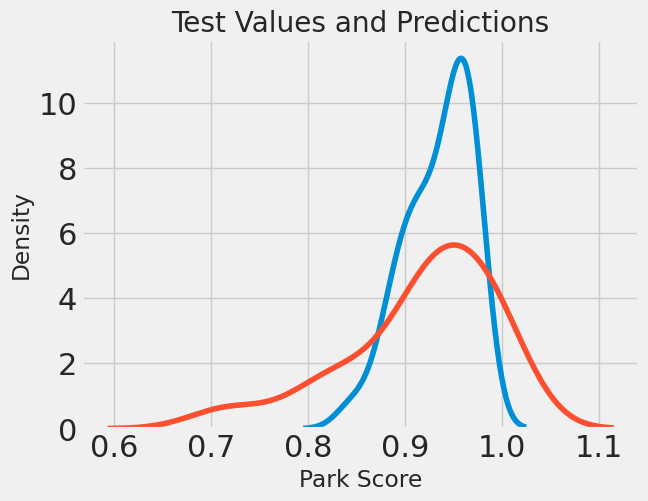

In [118]:
# Density plot of the final predictions and the test values
sns.kdeplot(y_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Park Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

In [119]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)

# Make predictions and evalute
model_pred = knn.predict(X_test)
model_mae = mae(y_test, model_pred)
r2 = r2_score(y_test, y_pred)
# Return the performance metric
print(f"Mean Squared Error: {mse:.2f}")
print(f"r^2: {r2}")

Mean Squared Error: 0.01
r^2: -0.3721911604370929


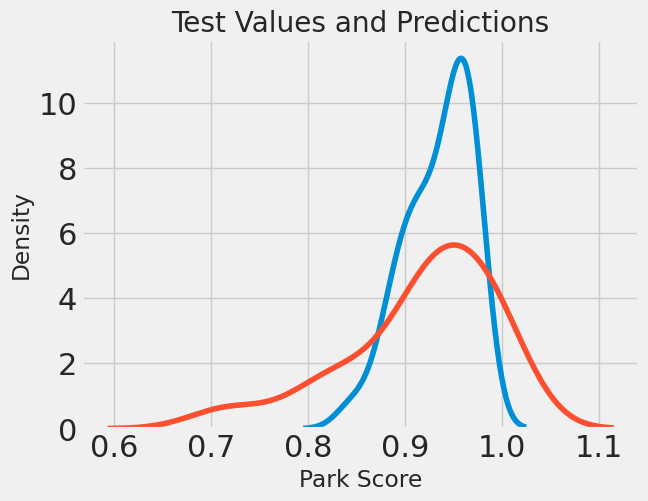

In [120]:
sns.kdeplot(y_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Park Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Похожий результат дал и KNN. Мы можем сделать вывод, что это задача не для МО.

##Кластеризация

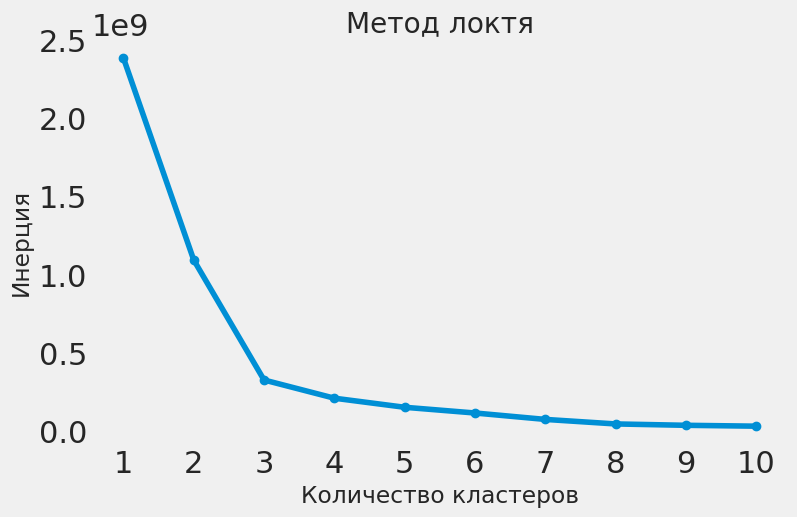

In [121]:
from sklearn.cluster import KMeans
# Список для хранения значений инерции
inertia = []

# Определяем количество кластеров от 1 до 10
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.xticks(k_values)
plt.grid()
plt.show()

In [122]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Обучаем модель на данных
kmeans.fit(features)

# Получаем метки кластеров и центры кластеров
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Получаем метки кластеров и центры кластеров
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print(features.columns)
# Выводим информацию о центрах кластеров
print("Центры кластеров:")
for i, center in enumerate(centers):
    print(f"Кластер {i + 1}: {center}")

# Выводим количество экземпляров в каждом кластере
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))

print("\nКоличество экземпляров в каждом кластере:")
for cluster, count in cluster_counts.items():
    print(f"Кластер {cluster + 1}: {count} экземпляров")

Index(['Square Feet', 'Perimeter Length', 'Floor Count',
       'Facility Type_Activity Center', 'Facility Type_Ball Field',
       'Facility Type_Clubhouse', 'Facility Type_Concession',
       'Facility Type_Fieldhouse', 'Facility Type_Maintenance Facility',
       'Facility Type_Picnic Area', 'PSA_PSA1', 'PSA_PSA2', 'PSA_PSA3',
       'PSA_PSA4', 'PSA_PSA5', 'PSA_PSA6'],
      dtype='object')
Центры кластеров:
Кластер 1: [1.74987706e+03 1.83477897e+02 6.11940299e-01 2.98507463e-02
 1.38777878e-17 2.53731343e-01 6.93889390e-18 1.49253731e-02
 4.47761194e-02 1.49253731e-02 3.88059701e-01 2.38805970e-01
 7.46268657e-02 7.46268657e-02 1.19402985e-01 1.04477612e-01]
Кластер 2: [ 7.20774217e+03  3.84304174e+02  1.02564103e-01  5.12820513e-02
 -3.46944695e-18  1.66533454e-16  2.56410256e-02 -1.73472348e-18
  1.38777878e-17 -1.73472348e-18  2.30769231e-01  1.79487179e-01
  5.12820513e-02  2.56410256e-01  1.53846154e-01  1.28205128e-01]
Кластер 3: [2.22981043e+04 8.18734380e+02 2.50000000e-01

##Time Series Analysis

Тем не менее, мы можем отследить по анализу временных рядов какие-то закономерности. Построим ряд для одного из парков:

In [123]:
new_df = pd.read_csv('SF_Park_Scores.csv')
new_df = new_df[new_df['Park'] == 'Carl Larsen Park']
new_df

,ParkID,PSA,Park,FQ,Score,Facility Type,Facility Name,Address,State,Zipcode,Floor Count,Square Feet,Perimeter Length,Acres,Longitude,Latitude
0,86,PSA4,Carl Larsen Park,FY05Q3,0.795,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
87,86,PSA4,Carl Larsen Park,FY06Q1,0.813,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
244,86,PSA4,Carl Larsen Park,FY06Q2,0.256,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
393,86,PSA4,Carl Larsen Park,FY06Q4,0.648,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
600,86,PSA4,Carl Larsen Park,FY07Q2,0.716,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
756,86,PSA4,Carl Larsen Park,FY07Q4,0.742,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
1049,86,PSA4,Carl Larsen Park,FY08Q2,0.849,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
1403,86,PSA4,Carl Larsen Park,FY09Q1,0.808,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
1707,86,PSA4,Carl Larsen Park,FY09Q2,0.779,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335
1800,86,PSA4,Carl Larsen Park,FY09Q3,0.959,Basketball Court,Ocean View Basketball Courts,Capitol & Montana St,CA,94112.0,NaN,5572.020314,311.982228,0.127916,-122.456708,37.716335


In [124]:
# Функция для преобразования строки в дату
def convert_fq_to_date(fq):
    # Извлекаем год и квартал
    year = int(fq[2:4]) + 2000  # Преобразуем FY05 в 2005
    quarter = int(fq[5])  # Извлекаем номер квартала
    # Определяем первый месяц квартала
    if quarter == 1:
        month = 1  # Январь
    elif quarter == 2:
        month = 4  # Апрель
    elif quarter == 3:
        month = 7  # Июль
    elif quarter == 4:
        month = 10  # Октябрь

    # Возвращаем дату первого дня квартала
    return pd.Timestamp(year=year, month=month, day=1)

# Создаем новый столбец с датами
new_df['Date'] = new_df['FQ'].apply(convert_fq_to_date)
new_df = new_df.sort_values(by='Date')
new_df.reset_index(drop=True, inplace=True)
# Выводим результат
print(new_df)

    ParkID   PSA              Park      FQ  Score     Facility Type  \
0       86  PSA4  Carl Larsen Park  FY05Q3  0.795  Basketball Court   
1       86  PSA4  Carl Larsen Park  FY06Q1  0.813  Basketball Court   
2       86  PSA4  Carl Larsen Park  FY06Q2  0.256  Basketball Court   
3       86  PSA4  Carl Larsen Park  FY06Q4  0.648  Basketball Court   
4       86  PSA4  Carl Larsen Park  FY07Q2  0.716  Basketball Court   
5       86  PSA4  Carl Larsen Park  FY07Q4  0.742  Basketball Court   
6       86  PSA4  Carl Larsen Park  FY08Q2  0.849  Basketball Court   
7       86  PSA4  Carl Larsen Park  FY09Q1  0.808  Basketball Court   
8       86  PSA4  Carl Larsen Park  FY09Q2  0.779  Basketball Court   
9       86  PSA4  Carl Larsen Park  FY09Q3  0.959  Basketball Court   
10      86  PSA4  Carl Larsen Park  FY09Q4  0.735  Basketball Court   
11      86  PSA4  Carl Larsen Park  FY10Q1  0.965  Basketball Court   
12      86  PSA4  Carl Larsen Park  FY10Q2  0.942  Basketball Court   
13    

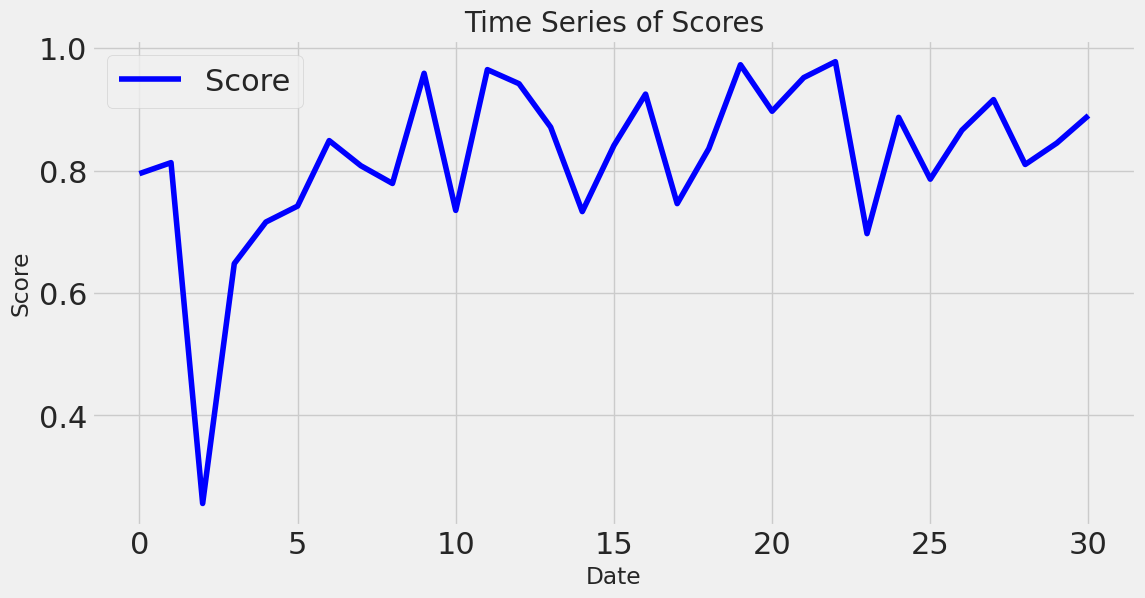

ADF Statistic: -4.205633172340565
p-value: 0.0006445815471077527


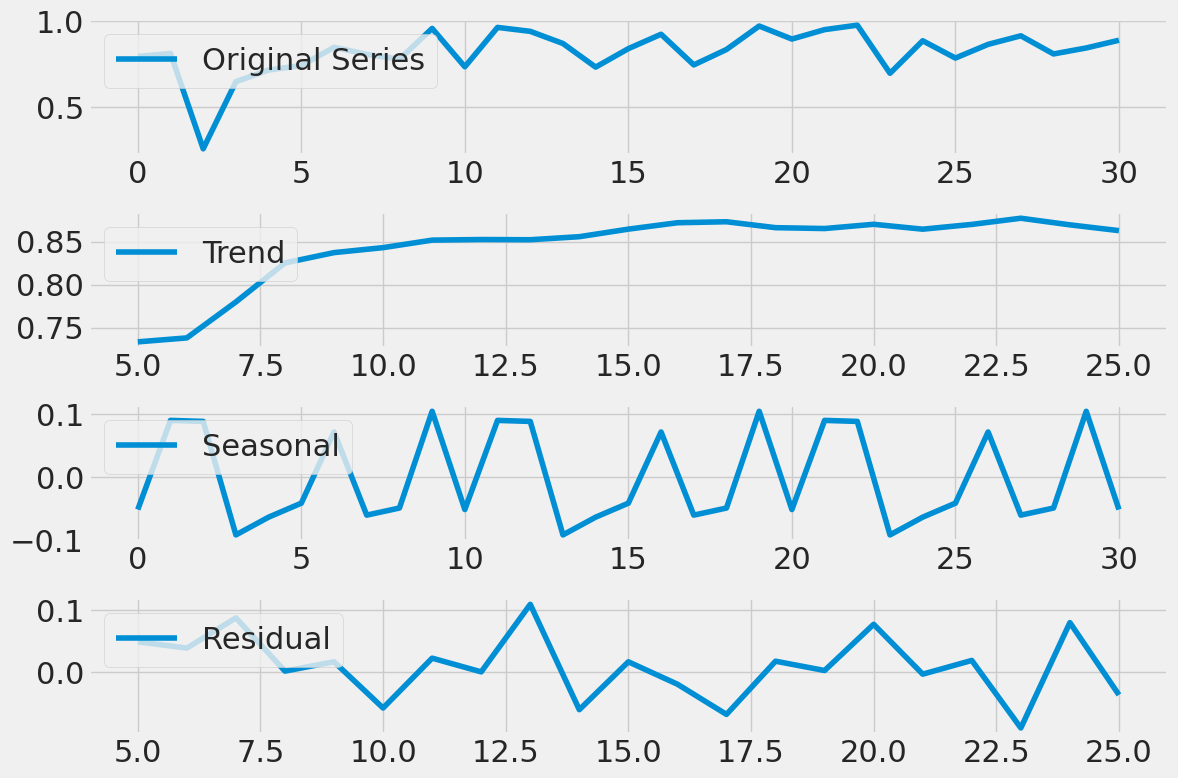

In [125]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df['Score'], label='Score', color='blue')
plt.title('Time Series of Scores')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.show()

# Проверка стационарности с помощью теста Дики-Фуллера
result = adfuller(new_df['Score'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Если p-value > 0.05, временной ряд не стационарен; нужно его дифференцировать
if result[1] > 0.05:
    new_df['Score_diff'] = new_df['Score'].diff().dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(new_df.index[1:], new_df['Score_diff'][1:], label='Differenced Score', color='orange')
    plt.title('Differenced Time Series of Scores')
    plt.xlabel('Date')
    plt.ylabel('Differenced Score')
    plt.legend()
    plt.show()
# Декомпозиция временного ряда
decomposition = seasonal_decompose(new_df['Score'], model='additive', period=10)  # Укажите период в зависимости от ваших данных
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(new_df['Score'], label='Original Series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Сама сезонность не очень сильно повлияла на парк. Есть взлеты как и в первом квартале года, так и в четвертом А вот глобальный тренд есть: со временем отслеживания парк показывает результаты все ближе и ближе к 1.

##Общие выводы

На данный момент у исследования есть несколько фатальных для решения проблем:
Во-первых, нам катастрофически не хватает данных с официального портала: при том, что они никак не менялись, каждый год оценка парков была разной. Нет данных о возможных мероприятиях в парке или о его
Во-вторых, есть подозрительные данные (несколько записей за один парк в один квартал) и имеется тренд к завышению оценок, что делает не очень полезной саму оценку.
Тем не менее, мы заметили влияние типов зданий в парках, а также фаворитизм к определенному типу беседок. При этом размер парка также влияет на его уровень.